In [23]:
import numpy as np
import torch
from torch import optim
from tqdm.autonotebook import tqdm

import pandas as pd

from inference.plot import plot_loss, plot_posterior
from simulate.simulate import simulate
from inference.plannar import NormalizingFlow
from inference.loss import LossTeaching

In [9]:
def train(x, y, r, u, w, n_u, n_w,
          flow_length=16, epochs=10000, initial_lr=0.01, batch_size=40,
          freq_update_loss=50):
    z_flow = NormalizingFlow(dim=(n_u + n_w) * 2, flow_length=flow_length)
    theta_flow = NormalizingFlow(6, flow_length=flow_length)

    loss_func = LossTeaching(x=x, y=y, r=r, u=u, w=w, n_u=n_u, n_w=n_w)

    optimizer = optim.Adam(
        list(z_flow.parameters()) + list(theta_flow.parameters()),
        lr=initial_lr)
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)

    hist_loss = np.zeros(epochs)

    with tqdm(total=epochs) as pbar:

        for i in range(epochs):

            optimizer.zero_grad()
            loss = loss_func(z_flow=z_flow,
                             theta_flow=theta_flow,
                             batch_size=batch_size)
            loss.backward()
            optimizer.step()
            # scheduler.step()

            hist_loss[i] = loss.item()

            if i % freq_update_loss == 0 and i > 0:
                pbar.set_postfix(
                    {'loss': np.mean(hist_loss[i - freq_update_loss:i])})
            pbar.update()

    return z_flow, theta_flow, hist_loss

In [32]:
data, truth = simulate()

In [33]:
df = pd.DataFrame({'u': data['u'],
                   'w': data['w'],
                   'x': data['x'],
                   'r': data['r'],
                   'y': data['y']})

In [34]:
n_u = len(df.u.unique())
n_w = len(df.w.unique())

In [35]:
N = len(df)

initial_lr=0.01

flow_length = 16

freq_update_loss = 5

n_epochs = 5000
batch_size = 128


z_flow = NormalizingFlow(dim=(n_u + n_w) * 2, flow_length=flow_length)
theta_flow = NormalizingFlow(6, flow_length=flow_length)

optimizer = optim.Adam(
    list(z_flow.parameters()) + list(theta_flow.parameters()),
    lr=initial_lr)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)

hist_loss = np.zeros(n_epochs)

with tqdm(total=n_epochs) as pbar:

    for epoch in range(n_epochs):

        # X is a torch Variable
        permutation = torch.randperm(N)

        for i in range(0,N, batch_size):

            indices = permutation[i:i+batch_size]

            batch = df.loc[indices]
            loss_func = LossTeaching(
                x=batch.x.values, 
                y=batch.y.values, 
                r=batch.r.values, 
                u=batch.u.values, 
                w=batch.w.values, 
                n_u=n_u, n_w=n_w)

            optimizer.zero_grad()
            loss = loss_func(z_flow=z_flow,
                             theta_flow=theta_flow,
                             batch_size=batch_size)
            loss.backward()
            optimizer.step()
            # scheduler.step()

        hist_loss[epoch] = loss.item()

        if epoch % freq_update_loss == 0 and epoch > 0:
            pbar.set_postfix(
                {'loss': np.mean(hist_loss[epoch - freq_update_loss:epoch])})
        pbar.update()

  0%|          | 0/5000 [00:00<?, ?it/s]

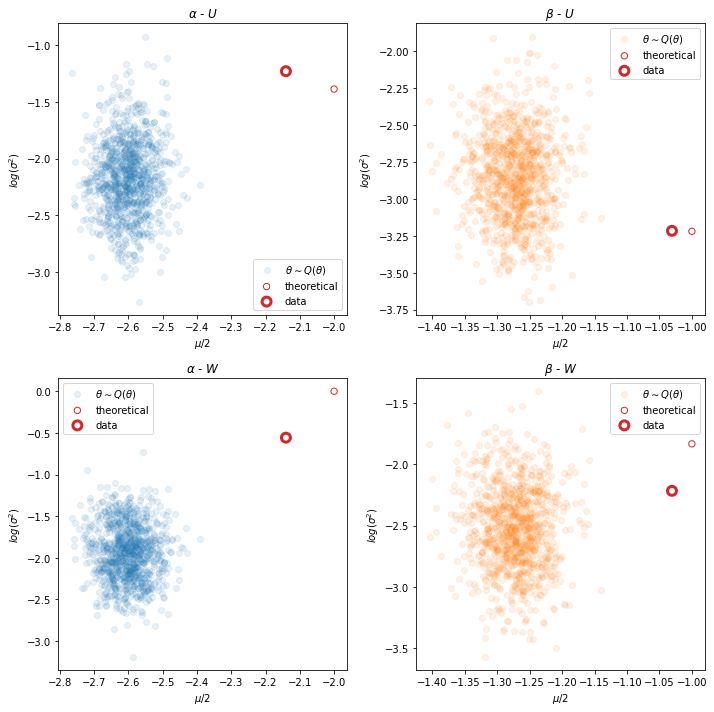

In [36]:
plot_posterior(theta_flow=theta_flow, 
               truth=truth, 
               name='artificial_mini_batch')

In [ ]:
plot_loss(hist_loss=hist_loss, name="artificial_mini_batch")